**문제 정의 : 타이타닉 생존자 예측 데이터 셋 사용하여 유무를 예측하는 이진 분류 문제로 정의<br>**
**사망 : 0, 생존 : 1**



**라이브러리 임포트** 

In [1]:
#Libraries for reading and handling the data
import numpy as np
import pandas as pd
import re

#Libraries for data visvalization
import matplotlib.pyplot as plt
import seaborn as sns

#Libraries for data preprocessing
from sklearn.model_selection import train_test_split
from  sklearn.preprocessing import StandardScaler, OrdinalEncoder,OneHotEncoder
from sklearn.compose import  ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

#Libraries for creating mL model
from sklearn.linear_model import  LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import  GradientBoostingClassifier


#library for anlysing the ml model
from sklearn import  metrics


 **데이터 준비하기**

In [2]:
train_path = 'train.csv'

target = 'Survived'

index = 'PassengerId'

dtypes = ({
    'Survived': bool, 
    'Pclass':   'category', 
    'Name':     'category',
    'Sex':      'category',
    'Age':      float,
    'SibSp':    int,
    'Parch':    int,
    'Ticket':  'category',
    'Fare':     float,
    'Cabin':   'category',
    'Embarked':'category'
})
# => 알려준대로 데이터셋을 가져옴

titanic = pd.read_csv(train_path, index_col=index, dtype = dtypes)




In [3]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    bool    
 1   Pclass    891 non-null    category
 2   Name      891 non-null    category
 3   Sex       891 non-null    category
 4   Age       714 non-null    float64 
 5   SibSp     891 non-null    int64   
 6   Parch     891 non-null    int64   
 7   Ticket    891 non-null    category
 8   Fare      891 non-null    float64 
 9   Cabin     204 non-null    category
 10  Embarked  889 non-null    category
dtypes: bool(1), category(6), float64(2), int64(2)
memory usage: 122.2 KB


**데이터 시각화**

In [4]:
titanic['Survived'].value_counts()

False    549
True     342
Name: Survived, dtype: int64

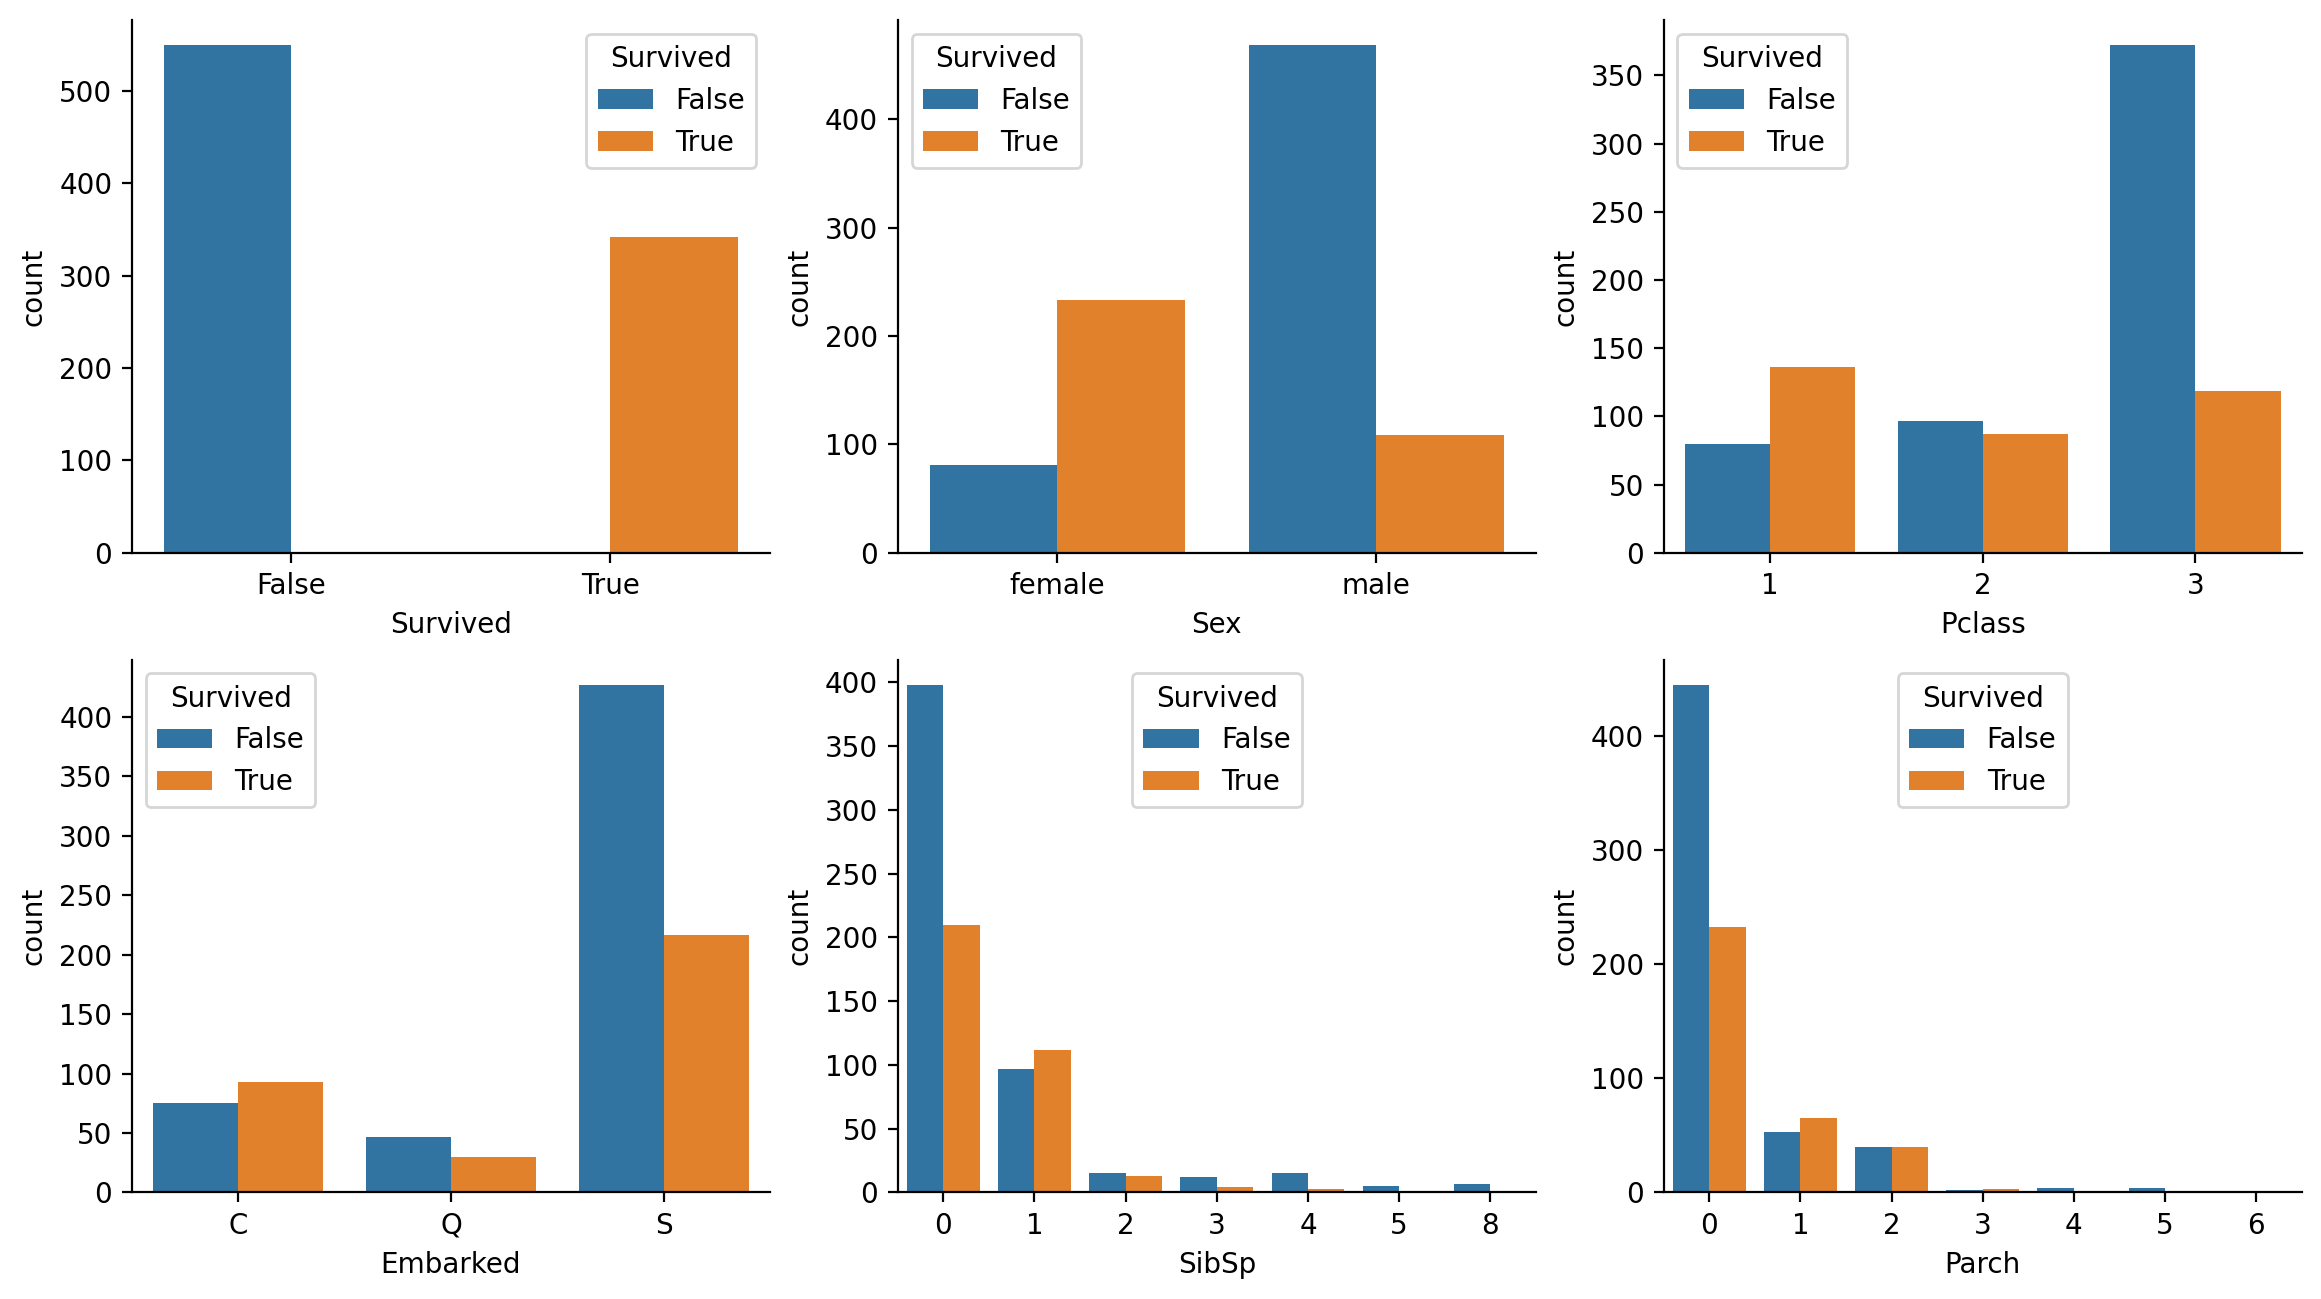

In [5]:
attributes = ['Survived', 'Sex', 'Pclass', 'Embarked', 'SibSp', 'Parch']

plt.figure(figsize=(14, 12), dpi=200)

for i, feature in enumerate(attributes) :
  plt.subplot(3, 3, i+1)
  sns.countplot(data=titanic, x=feature, hue = 'Survived')

sns.despine() # 테두리 제거

**데이터 전처리**

In [6]:
titanic['Name'].iloc[0:5]

PassengerId
1                              Braund, Mr. Owen Harris
2    Cumings, Mrs. John Bradley (Florence Briggs Th...
3                               Heikkinen, Miss. Laina
4         Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                             Allen, Mr. William Henry
Name: Name, dtype: category
Categories (891, object): ['Abbing, Mr. Anthony', 'Abbott, Mr. Rossmore Edward',
                           'Abbott, Mrs. Stanton (Rosa Hunt)', 'Abelson, Mr. Samuel', ..., 'de Pelsmaeker, Mr. Alfons',
                           'del Carlo, Mr. Sebastiano', 'van Billiard, Mr. Austin Blyler',
                           'van Melkebeke, Mr. Philemon']

In [7]:
def get_title(name):
    return re.split(',|\.',name)[1].strip()
    

In [8]:
#이름에서 호칭 추출(MIss,mr,mrs)
titanic['title'] = titanic['Name'].apply(get_title)

In [9]:
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title
PassengerId,,,,,,,,,,,,
1,False,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
2,True,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
3,True,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
4,True,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
5,False,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [10]:
#호칭에 생존에 과연 영향을 끼치는지 확인을 위해 집계함수
titles =titanic.groupby('title').agg({'Survived' : ['count','mean']})


In [11]:
# Survived 라는 column 레이어 정리
titles.columns = titles.columns.droplevel()

In [12]:
# 생존 평균이 높은 순으로 정렬
titles.sort_values('mean', ascending=False)

,count,mean
title,,
the Countess,1,1.000000
Mlle,2,1.000000
Sir,1,1.000000
Ms,1,1.000000
Lady,1,1.000000
Mme,1,1.000000
Mrs,125,0.792000
Miss,182,0.697802
Master,40,0.575000


In [13]:
#호칭 추출이 되지 않은 title 값을 other로 처리

uncommon_titles = (['Don', 'Rev', 'Dr', 'Mme', 'Ms', 'Major', 
                    'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 
                    'the Countess', 'Jonkheer'])
titanic['title'] = titanic['title'].replace(uncommon_titles, 'other')

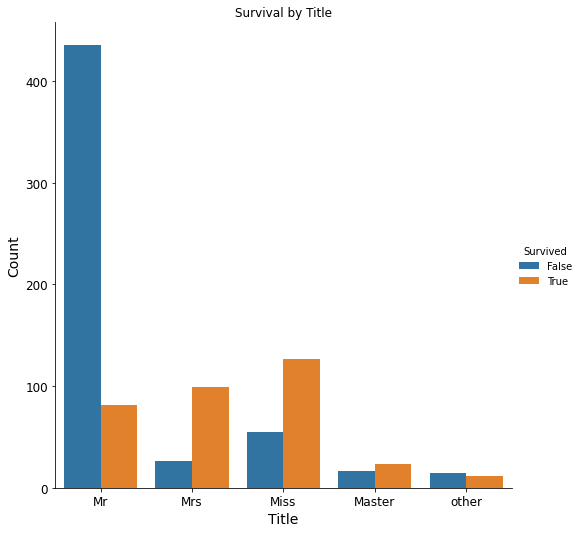

In [14]:
sns.catplot(x='title', kind = 'count', hue ='Survived', 
            data=titanic, height = 7)

plt.tick_params(labelsize =12)
plt.ylabel('Count', fontsize =14)
plt.xlabel('Title',fontsize =14)
plt.title('Survival by Title')
plt.show()

In [15]:
# 가족 사이즈 -> sibsp(동승한 자매or 배우자) + parch(동승한 부모 or 자식수)
titanic['fam_size'] = titanic['SibSp'] + titanic['Parch']


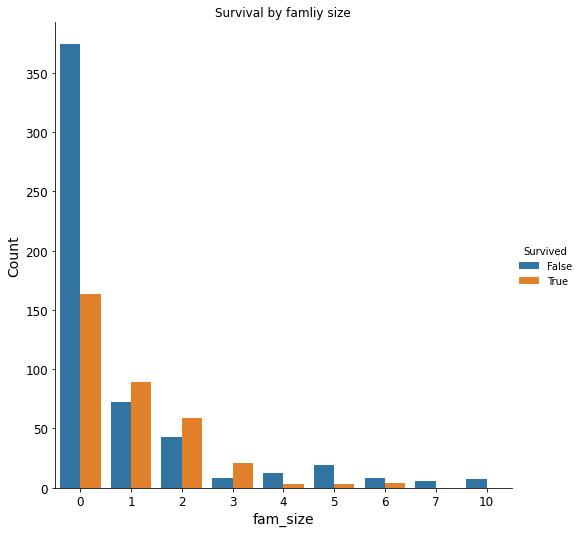

In [16]:
sns.catplot(x='fam_size', kind = 'count', hue ='Survived', 
            data=titanic, height = 7)

plt.tick_params(labelsize =12)
plt.ylabel('Count', fontsize =14)
plt.xlabel('fam_size',fontsize =14)
plt.title('Survival by famliy size')
plt.show()

**ML을 위한 전처리**

In [17]:
#텍스트 데이터 삭제 
titanic = titanic.drop(['Name','Ticket','Cabin', 'Embarked','title'], axis=1)


In [18]:
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,fam_size
PassengerId,,,,,,,,
1,False,3,male,22.0,1,0,7.2500,1
2,True,1,female,38.0,1,0,71.2833,1
3,True,3,female,26.0,0,0,7.9250,0
4,True,1,female,35.0,1,0,53.1000,1
5,False,3,male,35.0,0,0,8.0500,0


In [19]:
# 여성을 1로 남성을 0으로 처리
tmp =[]
for each in titanic['Sex']:
    if each == 'female':
        tmp.append(1)
    elif each == 'male':
        tmp.append(0)
    else:
        tmp.append(np.nan)

titanic['Sex'] =tmp

In [20]:
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,fam_size
PassengerId,,,,,,,,
1,False,3,0,22.0,1,0,7.2500,1
2,True,1,1,38.0,1,0,71.2833,1
3,True,3,1,26.0,0,0,7.9250,0
4,True,1,1,35.0,1,0,53.1000,1
5,False,3,0,35.0,0,0,8.0500,0


**데이터 형변환 및 결손 데이터 처리**

In [21]:
#데이터 형 변환 (소수점)

In [22]:
titanic['Pclass'] = titanic['Pclass'].astype('float')
titanic['Sex'] = titanic['Sex'].astype('float')
titanic['SibSp'] = titanic['SibSp'].astype('float')
titanic['Parch'] = titanic['Parch'].astype('float')
titanic['Fare'] = titanic['Fare'].astype('float')

#null(결손) 값인 경우 삭제
titanic = titanic[titanic['Survived'].notnull()]
titanic = titanic[titanic['Age'].notnull()]
titanic = titanic[titanic['SibSp'].notnull()]
titanic = titanic[titanic['Parch'].notnull()]
titanic = titanic[titanic['Fare'].notnull()]

titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  714 non-null    bool   
 1   Pclass    714 non-null    float64
 2   Sex       714 non-null    float64
 3   Age       714 non-null    float64
 4   SibSp     714 non-null    float64
 5   Parch     714 non-null    float64
 6   Fare      714 non-null    float64
 7   fam_size  714 non-null    int64  
dtypes: bool(1), float64(6), int64(1)
memory usage: 45.3 KB


**데이터 분리하기 X(문제집)y,(정답)**

In [23]:
titanic_labels = titanic['Survived'].copy()
titanic = titanic.drop('Survived',axis=1)

**훈련 데이터 , 테스트데이터셋 분리하기**


In [24]:
X_train,X_test, y_train,y_test = train_test_split(titanic,titanic_labels,train_size =0.8) 

**머신러닝 모델 구축 -1) LogisticRegression**

In [25]:
log_reg =LogisticRegression().fit(X_train, y_train)

In [26]:
#정확도 확인
print('Train data score:', log_reg.score(X_train,y_train))
print('test data score:', log_reg.score(X_test,y_test))

Train data score: 0.8108581436077058
test data score: 0.7692307692307693


**머신러닝 모델 구축 -2) Decision Tree**

In [27]:
tree = DecisionTreeClassifier(max_depth = 5,
                              min_samples_leaf = 20,
                              min_samples_split = 40).fit(X_train, y_train)

In [28]:
#정확도 확인
print('Train data score:', tree.score(X_train,y_train))
print('test data score:', tree.score(X_test,y_test))

Train data score: 0.8213660245183888
test data score: 0.7762237762237763


**머신러닝 모델 구축 -3)GradientBoostingClassifier**

In [29]:
boost = GradientBoostingClassifier(max_depth=3,
                                   learning_rate =0.05).fit(X_train, y_train)

In [30]:
#정확도 확인
print('Train data score:', boost.score(X_train,y_train))
print('test data score:', boost.score(X_test,y_test))

Train data score: 0.8896672504378283
test data score: 0.7412587412587412


**머신러닝 모델 구축 -4) RandomForestClassifier**

In [31]:
random = RandomForestClassifier(n_estimators=300, random_state=0).fit(X_train,y_train)

In [32]:
#정확도 확인
print('Train accuracy score is:', random.score(X_train,y_train))
print('test accuracy score is:', random.score(X_test,y_test))

Train accuracy score is: 0.989492119089317
test accuracy score is: 0.7412587412587412


**성능 평가 - Roc 커브**

In [33]:
def plot_auc_roc(model):
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

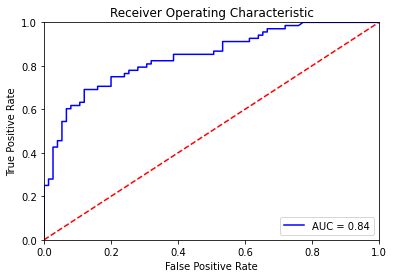

In [34]:
#Logistic Regression Roc
plot_auc_roc(log_reg)

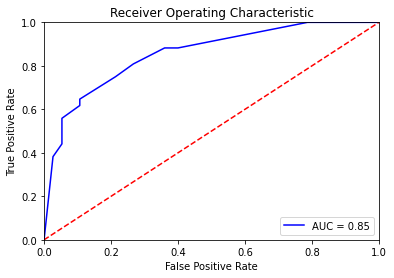

In [35]:
#Logistic decision tree
plot_auc_roc(tree)

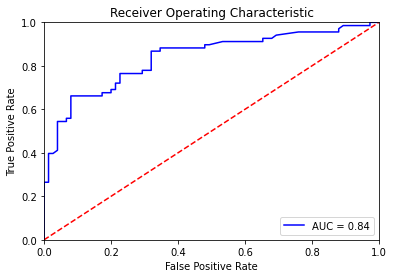

In [36]:
#GradientBoostingClassifie
plot_auc_roc(boost)

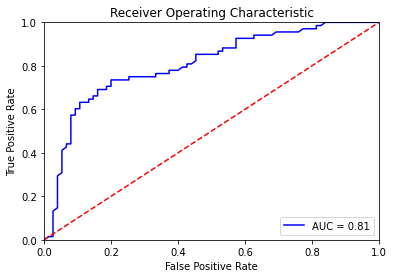

In [37]:
#for randomForestClassifier
plot_auc_roc(random)

성능평가 - 평가 지표(classification_report)

성능 평가 - precision_score, recall_score 각 모델별로 추출한 후 그래프로 시각화

In [38]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 1 to 891
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    714 non-null    float64
 1   Sex       714 non-null    float64
 2   Age       714 non-null    float64
 3   SibSp     714 non-null    float64
 4   Parch     714 non-null    float64
 5   Fare      714 non-null    float64
 6   fam_size  714 non-null    int64  
dtypes: float64(6), int64(1)
memory usage: 44.6 KB


In [39]:
precision_list =[]
recall = []

In [40]:
#Logistic Regression 평가 지표

lg_y_hat = log_reg.predict(X_test)
lg_report = metrics.classification_report(y_test,lg_y_hat)

print('Logistic Regression 평가지표')
print(lg_report)
print('accuracy', metrics.accuracy_score(y_test,lg_y_hat) )
print('precision', metrics.precision_score(y_test,lg_y_hat) )
print('recall', metrics.recall_score(y_test,lg_y_hat) )
print('f1', metrics.f1_score(y_test,lg_y_hat) )

Logistic Regression 평가지표
              precision    recall  f1-score   support

       False       0.76      0.83      0.79        75
        True       0.79      0.71      0.74        68

    accuracy                           0.77       143
   macro avg       0.77      0.77      0.77       143
weighted avg       0.77      0.77      0.77       143

accuracy 0.7692307692307693
precision 0.7868852459016393
recall 0.7058823529411765
f1 0.7441860465116278


In [41]:
#tree 평가 지표
tree_y_hat = tree.predict(X_test)
tree_report = metrics.classification_report(y_test,tree_y_hat)

print('tree 평가지표')
print(tree_report)
print('accuracy', metrics.accuracy_score(y_test,tree_y_hat) )
print('precision', metrics.precision_score(y_test,tree_y_hat) )
print('recall', metrics.recall_score(y_test,tree_y_hat) )
print('f1', metrics.f1_score(y_test,tree_y_hat) )

tree 평가지표
              precision    recall  f1-score   support

       False       0.74      0.89      0.81        75
        True       0.85      0.65      0.73        68

    accuracy                           0.78       143
   macro avg       0.79      0.77      0.77       143
weighted avg       0.79      0.78      0.77       143

accuracy 0.7762237762237763
precision 0.8461538461538461
recall 0.6470588235294118
f1 0.7333333333333334


In [42]:
#boost 평가 지표
boost_y_hat = boost.predict(X_test)
boost_report = metrics.classification_report(y_test,boost_y_hat)

print('tree 평가지표')
print(boost_report)
print('accuracy', metrics.accuracy_score(y_test,boost_y_hat) )
print('precision', metrics.precision_score(y_test,boost_y_hat) )
print('recall', metrics.recall_score(y_test,boost_y_hat) )
print('f1', metrics.f1_score(y_test,boost_y_hat) )

tree 평가지표
              precision    recall  f1-score   support

       False       0.73      0.80      0.76        75
        True       0.75      0.68      0.71        68

    accuracy                           0.74       143
   macro avg       0.74      0.74      0.74       143
weighted avg       0.74      0.74      0.74       143

accuracy 0.7412587412587412
precision 0.7540983606557377
recall 0.6764705882352942
f1 0.7131782945736433


In [43]:
#random 평가 지표
random_y_hat = boost.predict(X_test)
random_report = metrics.classification_report(y_test,boost_y_hat)

print('random 평가지표')
print(random_report)
print('accuracy', metrics.accuracy_score(y_test,boost_y_hat) )
print('precision', metrics.precision_score(y_test,boost_y_hat) )
print('recall', metrics.recall_score(y_test,boost_y_hat) )
print('f1', metrics.f1_score(y_test,boost_y_hat) )

random 평가지표
              precision    recall  f1-score   support

       False       0.73      0.80      0.76        75
        True       0.75      0.68      0.71        68

    accuracy                           0.74       143
   macro avg       0.74      0.74      0.74       143
weighted avg       0.74      0.74      0.74       143

accuracy 0.7412587412587412
precision 0.7540983606557377
recall 0.6764705882352942
f1 0.7131782945736433


In [44]:
precision_list =[]
recall_list = []

precision_list.append(metrics.precision_score(y_test,lg_y_hat))
recall_list.append(metrics.recall_score(y_test,lg_y_hat))

precision_list.append(metrics.precision_score(y_test,tree_y_hat))
recall_list.append(metrics.recall_score(y_test,tree_y_hat))

precision_list.append(metrics.precision_score(y_test,boost_y_hat))
recall_list.append(metrics.recall_score(y_test,boost_y_hat))

precision_list.append(metrics.precision_score(y_test,random_y_hat))
recall_list.append(metrics.recall_score(y_test,random_y_hat))

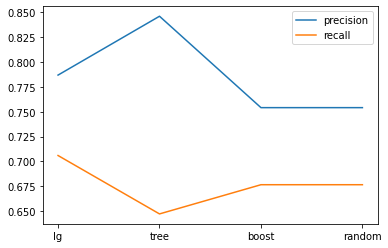

In [48]:
plt.plot(['lg','tree','boost','random'],precision_list, label ='precision')
plt.plot(['lg','tree','boost','random'],recall_list, label ='recall')
plt.legend()
plt.show()
#사망, 진료 등은 recall (오진단시 recall)

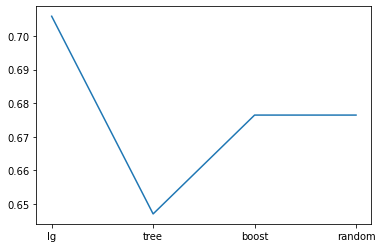

In [49]:
plt.plot(['lg','tree','boost','random'],recall_list)